In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
import plotly.express as px
from tensorflow.keras.optimizers import RMSprop
from keras.layers import LSTM 
from keras.regularizers import l1
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from keras.layers.convolutional import MaxPooling1D, Conv1D
from tensorflow.keras.layers import Dense, Dropout, Flatten,LSTM, Bidirectional, TimeDistributed, ConvLSTM2D,GRU,RepeatVector


2023-03-26 14:15:00.479057: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 14:15:00.585501: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 14:15:00.586690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 14:15:01.790717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import glob
all_f= glob.glob('../'+'DataSets/'+'*/'+'*/'+'*_INDEX_*.csv')
all_f

['../DataSets/RAJASTHAN/BHIWADI/H_Bhiw_1_12_17-2_12_22-*01* (copy)_INDEX_Mean.csv',
 '../DataSets/RAJASTHAN/JODHPUR/H_Jodh_1_12_15-2_12_22-*10* (copy)_INDEX_Mean.csv',
 '../DataSets/MADHYA_PRADESH/SINGRAULI/H_Sing_1_12_17-2_12_22-*48* (copy)_INDEX_Mean.csv',
 '../DataSets/GUJARAT/ANKLESHWAR/H_Ankl_1_2_19-3_12_22-*41* (copy)_INDEX_Mean.csv',
 '../DataSets/PUNJAB/LUDHIANA/H_Ludh_1_5_17-_2_12_22-*07* (copy)_INDEX_Mean.csv',
 '../DataSets/WEST_BENGAL/DURGAPUR/H_Durg_1_12_17-2_12_22-*58* (copy)_INDEX_Median.csv',
 '../DataSets/HARYANA/YAMUNA_NAGAR/H_Yamu_1_1_19-2_12_22-*30* (copy)_INDEX_Mean.csv',
 '../DataSets/HARYANA/CHARKHI_DADRI/H_Char_1_3_20-2_12_22-*58* (copy)_INDEX_Mean.csv',
 '../DataSets/HARYANA/JIND/H_Jind_1_1_19-2_12_22-*56* (copy)_INDEX_Median.csv',
 '../DataSets/HARYANA/KURUKSHETRA/H_Kuru_1_1_19-2_12_12-*48* (copy)_INDEX_Mean.csv',
 '../DataSets/HARYANA/SONIPAT/H_Soni_1_1_19-2_12_22-*21* (copy)_INDEX_Mean.csv',
 '../DataSets/HARYANA/DHARUHERA/H_Dhar_1_1_19-2_12_22-*43* (copy)_I

In [3]:
li=[]
for file_name in all_f:
    df=pd.read_csv(file_name)
    li.append(df)


In [4]:
s_n=1
df=li[s_n]
df,all_f[s_n]

(                      DATE  PM2.5
 0      2015-12-01 00:00:00  52.97
 1      2015-12-01 01:00:00  50.10
 2      2015-12-01 02:00:00  53.32
 3      2015-12-01 03:00:00  55.84
 4      2015-12-01 04:00:00  65.57
 ...                    ...    ...
 61404  2022-12-02 12:00:00  75.94
 61405  2022-12-02 13:00:00  58.98
 61406  2022-12-02 14:00:00  48.72
 61407  2022-12-02 15:00:00  36.51
 61408  2022-12-02 16:00:00  18.57
 
 [61409 rows x 2 columns],
 '../DataSets/RAJASTHAN/JODHPUR/H_Jodh_1_12_15-2_12_22-*10* (copy)_INDEX_Mean.csv')

In [5]:
v=all_f[s_n].split(r"/")
#u=v[3].split(r' ')
Pre_Ds=v[0]+'/'+'Results/'+v[2]+'/'+v[3]+'/'
Pre_Ds

'../Results/RAJASTHAN/JODHPUR/'

In [6]:
#df=df.iloc[-26304:,:]
df['DATE']=pd.to_datetime(df['DATE'])
df=df.rename(columns={'PM2.5':'PM'})
df['PM']=df['PM'].astype('float32')
df=df.reset_index()
df=df.drop(['index'], axis = 1) 
#df.drop(['level_0'], axis = 1, inplace = True) 
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61409 entries, 0 to 61408
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    61409 non-null  datetime64[ns]
 1   PM      61409 non-null  float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 719.8 KB


,DATE,PM
0,2015-12-01 00:00:00,52.970001
1,2015-12-01 01:00:00,50.099998
2,2015-12-01 02:00:00,53.320000
3,2015-12-01 03:00:00,55.840000
4,2015-12-01 04:00:00,65.570000
...,...,...
61404,2022-12-02 12:00:00,75.940002
61405,2022-12-02 13:00:00,58.980000
61406,2022-12-02 14:00:00,48.720001
61407,2022-12-02 15:00:00,36.509998


In [7]:
df.set_index('DATE',inplace = True)

In [8]:
values=df.values
scaler=MinMaxScaler(feature_range=(0,1))
scaled=scaler.fit_transform(values)

In [9]:
train,test=train_test_split(scaled,test_size=0.30,shuffle=False)
train_target=train[:]
test_target=test[:]
train_target.shape,test_target.shape

((42986, 1), (18423, 1))

In [10]:
n_input = 24
n_features =1
b_size=10
train_generator = TimeseriesGenerator(train, train_target, length = n_input, batch_size=b_size)
print(len(train),len(train_generator))

x,y=train_generator[50]

test_generator = TimeseriesGenerator(test,test_target,length= n_input,batch_size=b_size)
print(len(test),len(test_generator))
test_generator[0][0],test_generator[0][1]

x,y = test_generator[0]

print(x.shape,y.shape,test.shape)

42986 4297
18423 1840
(10, 24, 1) (10, 1) (18423, 1)


In [11]:
# attention define by the machine learning mastery
import keras.backend as K
from keras.layers import Layer

# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 1D CNN

In [13]:
def my_checkpoint(Model):
    mc = ModelCheckpoint('Model_' +'best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    return mc

mc=my_checkpoint(LSTM)
#Define Model 
model = tf.keras.models.Sequential() # intialize the model

model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(n_input, n_features), kernel_regularizer=l1(0.002), bias_regularizer=l1(0.4)))
#model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', bias_regularizer=l1(0.5)))

#BatchNormalization()
model.add(MaxPooling1D(pool_size=1)) 
#model.add(Dropout(0.3))
model.add(Flatten())
#model.add(Dense(100, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(train_generator, validation_data=test_generator, epochs=500, steps_per_epoch=32, shuffle=True,callbacks=[es],verbose=0 )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 256)           768       
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 128)           65664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 22, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2816)              0         
                                                                 
 dense (Dense)               (None, 64)                180288    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

2023-03-26 14:15:04.047832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-03-26 14:15:05.140908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 23: early stopping


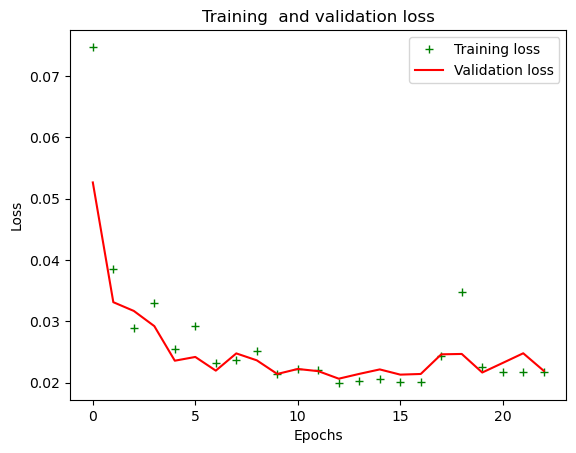

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, 'g+', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training  and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
prediction=model.predict(test_generator)
prediction.shape

  24/1840 [..............................] - ETA: 4s  

2023-03-26 14:16:31.544415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1840/1840 [==============================] - 5s 2ms/step


(18399, 1)

In [16]:
from keras.layers import concatenate
print(test.shape)
test1=test[n_input:,:]
print(test1.shape)
print(type(test1))
print(type(prediction))
prediction1 = concatenate((prediction,test1), axis=1)


(18423, 1)
(18399, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:
rescaled_prediction = scaler.inverse_transform(prediction1)
print('rescaled_prediction shape', rescaled_prediction.shape)
#print(rescaled_prediction[-5:,0])
#print(rescaled_prediction[:,0])
rescaled_prediction_pollution=rescaled_prediction[:len(test_generator),0]
print(rescaled_prediction_pollution.shape)
test_data_actual_scale=scaler.inverse_transform(test)
print('test_data_actual_scale shape', test_data_actual_scale.shape)
test_data_actual_pollution=test_data_actual_scale[22:len(test_generator)+22,0]
#test_data_actual_pollution=test_data_actual_scale[0:30,0]
print(test_data_actual_pollution.shape)

rescaled_prediction shape (18399, 2)
(1840,)
test_data_actual_scale shape (18423, 1)
(1840,)


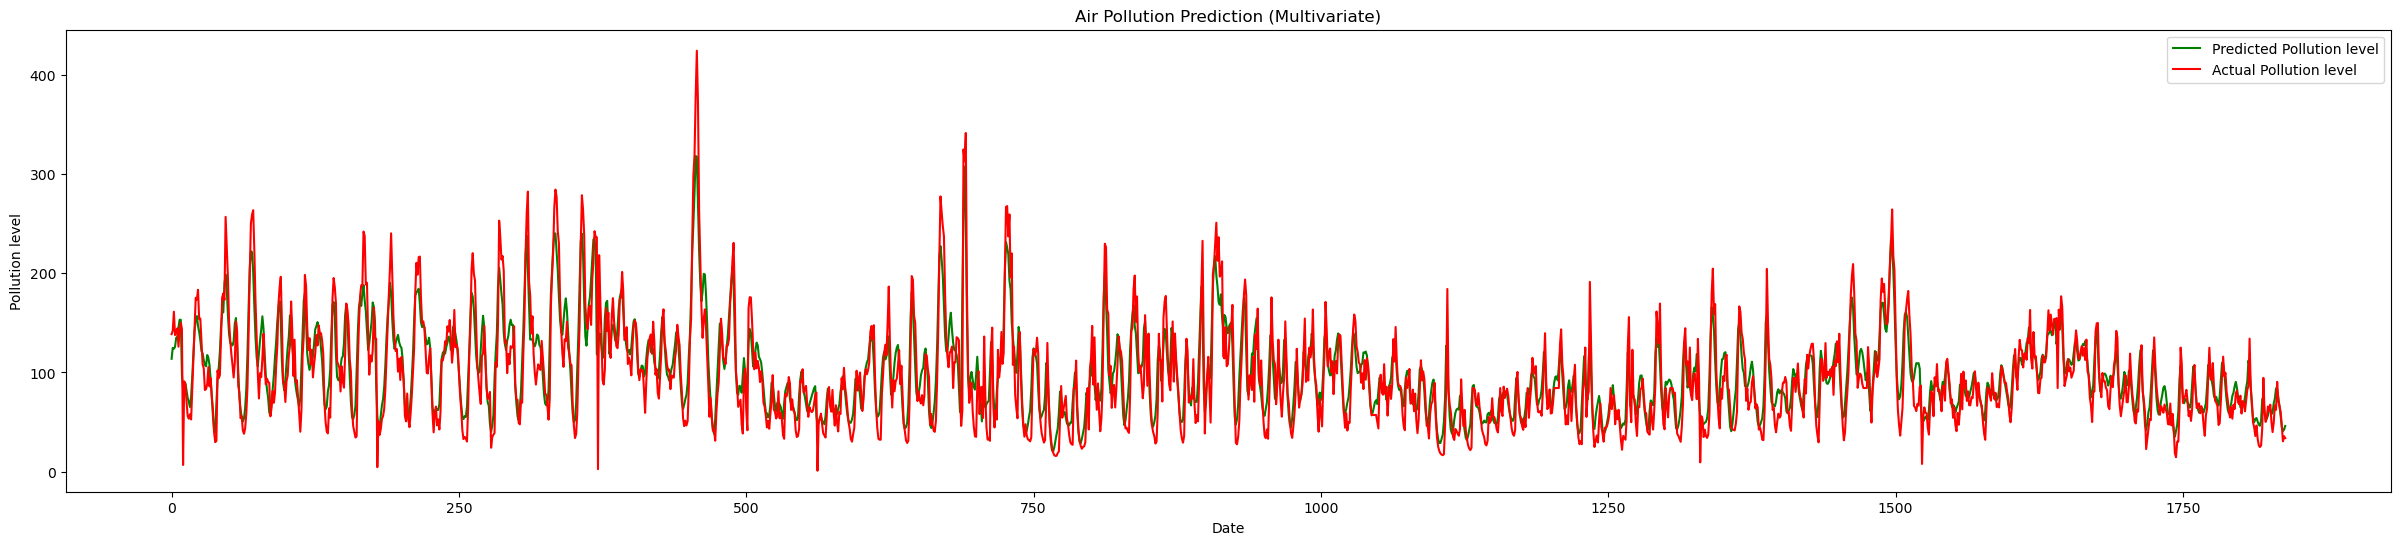

In [18]:
plt.figure(figsize=(30,6))  
plt.plot(rescaled_prediction_pollution, color= 'green', label = 'Predicted Pollution level')
plt.plot(test_data_actual_pollution , color = 'red', label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()

In [19]:
from math import sqrt
rmse = sqrt(mean_squared_error(rescaled_prediction_pollution,test_data_actual_pollution))
print('Test RMSE: %.3f' % rmse)

from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(test_data_actual_pollution,rescaled_prediction_pollution)
print('Test MAE: %.3f' % mae)

from sklearn.metrics import mean_absolute_percentage_error
mape=mean_absolute_percentage_error(test_data_actual_pollution,rescaled_prediction_pollution)
print('Test MAPE: %.3f' % mape)

Test RMSE: 23.133
Test MAE: 17.610
Test MAPE: 0.306


In [20]:
v1=v[3]
res=pd.read_csv('../RESULT_Sheet1.csv')
res=res.set_index('DataSets')
res.at[str(v1), 'C-R'] = rmse
res.at[str(v1), 'C-MA'] = mae
res.at[str(v1), 'C-MP'] = mape
res.to_csv('../RESULT_Sheet1.csv')

f__n= glob.glob('*.ipynb')
f_n=f__n[2].split(f'.')
f_n[0]

In [21]:
'''df1=pd.DataFrame()
df1[f_n[0]+'_actual'] = pd.DataFrame(test_data_actual_pollution)
df1[f_n[0]+'_predicted']=pd.DataFrame(rescaled_prediction_pollution)
df1.to_csv('../Pri_DataSets/'+v[3]+'.csv')'''
df1=pd.read_csv('../Pri_DataSets/'+v[3]+'.csv')
#df1['bilstm_actual'] = pd.DataFrame(test_data_actual_pollution)
df1['CNN_1D'+'_predicted']=pd.DataFrame(rescaled_prediction_pollution)
df1.to_csv('../Pri_DataSets/'+v[3]+'.csv')

# GRU

In [22]:
def my_checkpoint(Model):
    mc = ModelCheckpoint('Model_' +'best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    return mc

mc=my_checkpoint(LSTM)
#Define Model 
model = tf.keras.models.Sequential() # intialize the model

# Input layer
model.add(GRU (units = 256,  return_sequences = True,input_shape = (n_input, n_features),kernel_regularizer=l1(0.002), bias_regularizer=l1(0.4)))
model.add(Dropout(0.2)) 
    # Hidden layer
model.add(GRU(units = 128, bias_regularizer=l1(0.5)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(train_generator, validation_data=test_generator, epochs=500, steps_per_epoch=32, shuffle=True,callbacks=[es],verbose=1)

2023-03-26 14:16:37.878550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 14:16:37.880440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 14:16:37.881780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 256)           198912    
                                                                 
 dropout (Dropout)           (None, 24, 256)           0         
                                                                 
 gru_1 (GRU)                 (None, 128)               148224    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 347,265
Trainable params: 347,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500


2023-03-26 14:16:38.106056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 14:16:38.107581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 14:16:38.108854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - ETA: 0s - loss: 0.2801

2023-03-26 14:16:43.871859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-03-26 14:16:44.174264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 14:16:44.177045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

32/32 [==============================] - 23s 628ms/step - loss: 0.2801 - val_loss: 0.1681
Epoch 2/500
32/32 [==============================] - 18s 583ms/step - loss: 0.1550 - val_loss: 0.1416
Epoch 3/500
32/32 [==============================] - 18s 580ms/step - loss: 0.1355 - val_loss: 0.1294
Epoch 4/500
32/32 [==============================] - 18s 579ms/step - loss: 0.1344 - val_loss: 0.1221
Epoch 5/500
32/32 [==============================] - 18s 582ms/step - loss: 0.1298 - val_loss: 0.1314
Epoch 6/500
32/32 [==============================] - 18s 583ms/step - loss: 0.1288 - val_loss: 0.1251
Epoch 7/500
32/32 [==============================] - 18s 589ms/step - loss: 0.1281 - val_loss: 0.1207
Epoch 8/500
32/32 [==============================] - 18s 579ms/step - loss: 0.1280 - val_loss: 0.1214
Epoch 9/500
32/32 [==============================] - 18s 580ms/step - loss: 0.1265 - val_loss: 0.1256
Epoch 10/500
32/32 [==============================] - 18s 582ms/step - loss: 0.1275 - val_loss

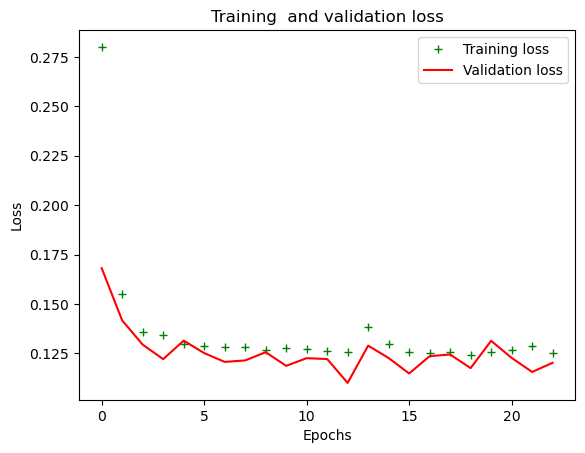

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, 'g+', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training  and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
prediction=model.predict(test_generator)
prediction.shape

from keras.layers import concatenate
print(test.shape)
test1=test[n_input:,:]
print(test1.shape)
print(type(test1))
print(type(prediction))
prediction1 = concatenate((prediction,test1), axis=1)

rescaled_prediction = scaler.inverse_transform(prediction1)
print('rescaled_prediction shape', rescaled_prediction.shape)
#print(rescaled_prediction[-5:,0])
#print(rescaled_prediction[:,0])
rescaled_prediction_pollution=rescaled_prediction[:len(test_generator),0]
print(rescaled_prediction_pollution.shape)
test_data_actual_scale=scaler.inverse_transform(test)
print('test_data_actual_scale shape', test_data_actual_scale.shape)
test_data_actual_pollution=test_data_actual_scale[22:len(test_generator)+22,0]
#test_data_actual_pollution=test_data_actual_scale[0:30,0]
print(test_data_actual_pollution.shape)

2023-03-26 14:23:45.330408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-03-26 14:23:45.622776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 14:23:45.625231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

1840/1840 [==============================] - 21s 11ms/step
(18423, 1)
(18399, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
rescaled_prediction shape (18399, 2)
(1840,)
test_data_actual_scale shape (18423, 1)
(1840,)


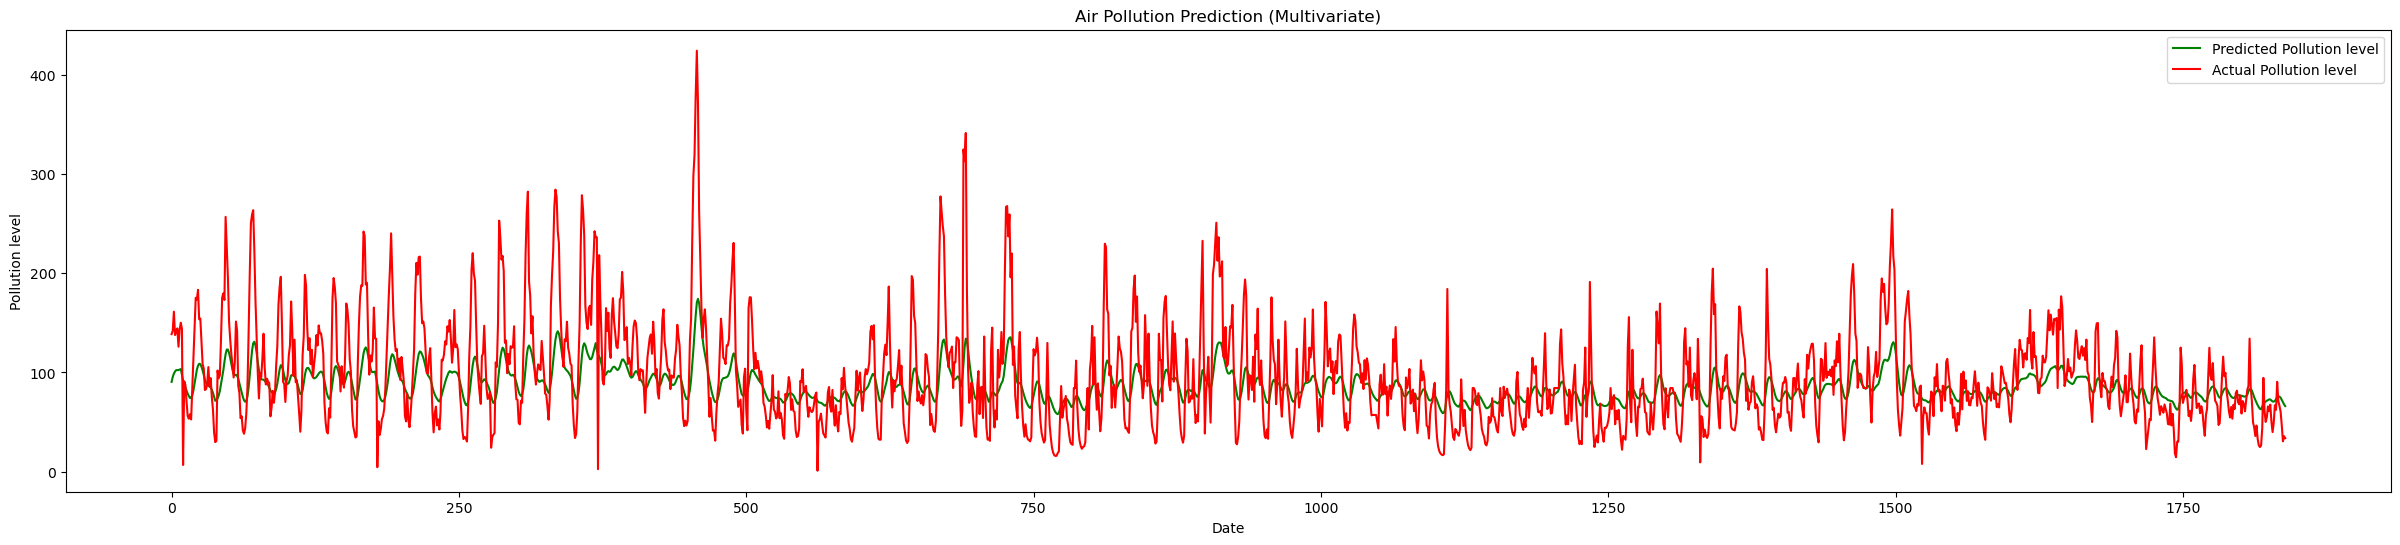

In [25]:
plt.figure(figsize=(30,6))  
plt.plot(rescaled_prediction_pollution, color= 'green', label = 'Predicted Pollution level')
plt.plot(test_data_actual_pollution , color = 'red', label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()

In [26]:
from math import sqrt
rmse = sqrt(mean_squared_error(rescaled_prediction_pollution,test_data_actual_pollution))
print('Test RMSE: %.3f' % rmse)

from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(test_data_actual_pollution,rescaled_prediction_pollution)
print('Test MAE: %.3f' % mae)

from sklearn.metrics import mean_absolute_percentage_error
mape=mean_absolute_percentage_error(test_data_actual_pollution,rescaled_prediction_pollution)
print('Test MAPE: %.3f' % mape)

Test RMSE: 41.061
Test MAE: 29.409
Test MAPE: 0.448


In [27]:
v1=v[3]
res=pd.read_csv('../RESULT_Sheet1.csv')
res=res.set_index('DataSets')
res.at[str(v1), 'G-R'] = rmse
res.at[str(v1), 'G-MA'] = mae
res.at[str(v1), 'G-MP'] = mape
res.to_csv('../RESULT_Sheet1.csv')

In [28]:
df1=pd.read_csv('../Pri_DataSets/'+v[3]+'.csv')
#df1['bilstm_actual'] = pd.DataFrame(test_data_actual_pollution)
df1['GRU'+'_predicted']=pd.DataFrame(rescaled_prediction_pollution)
df1.to_csv('../Pri_DataSets/'+v[3]+'.csv')

# V lSTM

In [29]:
def my_checkpoint(Model):
    mc = ModelCheckpoint('Model_' +'best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    return mc
mc=my_checkpoint(LSTM)

model = tf.keras.models.Sequential() 

model.add(LSTM(128, activation='relu',input_shape=(n_input, n_features),return_sequences=False, bias_regularizer=l1(0.4)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

history = model.fit(train_generator, validation_data=test_generator, epochs=500, steps_per_epoch=32, shuffle=True, callbacks=[es] )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500


2023-03-26 14:24:07.191723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


30/32 [===========================>..] - ETA: 0s - loss: 50.1692

2023-03-26 14:24:09.072728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 11s 328ms/step - loss: 50.1111 - val_loss: 49.1813
Epoch 2/500
32/32 [==============================] - 13s 434ms/step - loss: 48.3606 - val_loss: 47.5344
Epoch 3/500
32/32 [==============================] - 10s 309ms/step - loss: 46.7240 - val_loss: 45.8995
Epoch 4/500
32/32 [==============================] - 9s 300ms/step - loss: 45.0848 - val_loss: 44.2602
Epoch 5/500
32/32 [==============================] - 10s 320ms/step - loss: 43.4461 - val_loss: 42.6228
Epoch 6/500
32/32 [==============================] - 10s 309ms/step - loss: 41.8080 - val_loss: 40.9855
Epoch 7/500
32/32 [==============================] - 9s 291ms/step - loss: 40.1707 - val_loss: 39.3495
Epoch 8/500
32/32 [==============================] - 10s 306ms/step - loss: 38.5333 - val_loss: 37.7103
Epoch 9/500
32/32 [==============================] - 9s 288ms/step - loss: 36.9042 - val_loss: 36.0713
Epoch 10/500
32/32 [==============================] - 10s 325ms/step - loss: 35

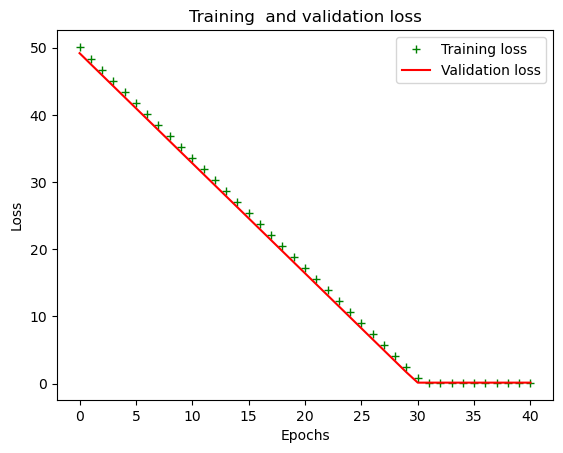

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, 'g+', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training  and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
prediction=model.predict(test_generator)
prediction.shape

from keras.layers import concatenate
print(test.shape)
test1=test[n_input:,:]
print(test1.shape)
print(type(test1))
print(type(prediction))
prediction1 = concatenate((prediction,test1), axis=1)

rescaled_prediction = scaler.inverse_transform(prediction1)
print('rescaled_prediction shape', rescaled_prediction.shape)
#print(rescaled_prediction[-5:,0])
#print(rescaled_prediction[:,0])
rescaled_prediction_pollution=rescaled_prediction[:len(test_generator),0]
print(rescaled_prediction_pollution.shape)
test_data_actual_scale=scaler.inverse_transform(test)
print('test_data_actual_scale shape', test_data_actual_scale.shape)
test_data_actual_pollution=test_data_actual_scale[22:len(test_generator)+22,0]
#test_data_actual_pollution=test_data_actual_scale[0:30,0]
print(test_data_actual_pollution.shape)

   1/1840 [..............................] - ETA: 5:25

2023-03-26 14:35:00.615672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1840/1840 [==============================] - 11s 6ms/step
(18423, 1)
(18399, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
rescaled_prediction shape (18399, 2)
(1840,)
test_data_actual_scale shape (18423, 1)
(1840,)


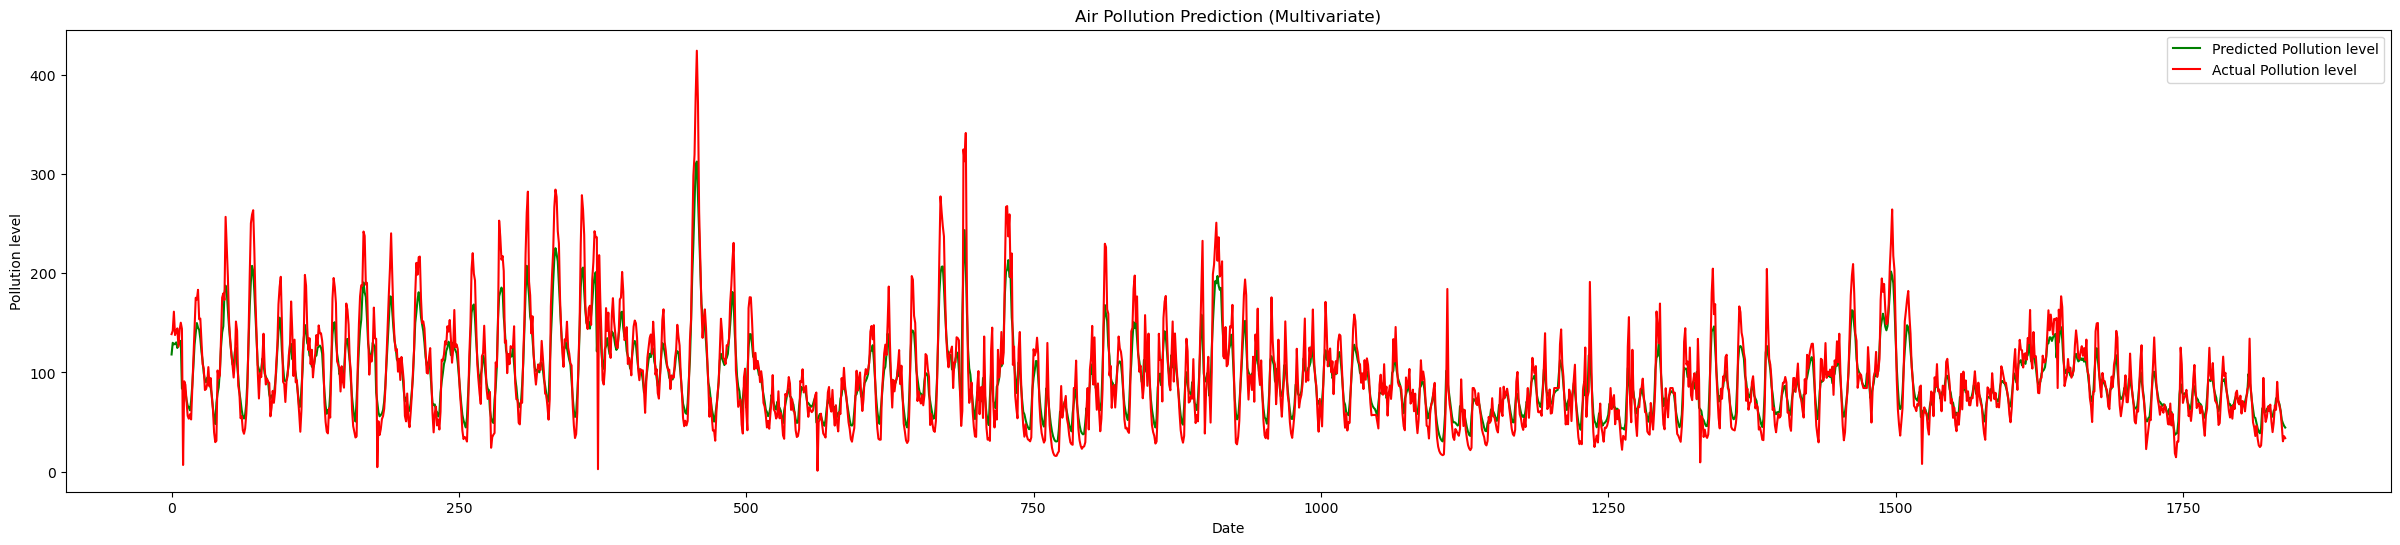

In [32]:
plt.figure(figsize=(30,6))  
plt.plot(rescaled_prediction_pollution, color= 'green', label = 'Predicted Pollution level')
plt.plot(test_data_actual_pollution , color = 'red', label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()

In [33]:
from math import sqrt
rmse = sqrt(mean_squared_error(rescaled_prediction_pollution,test_data_actual_pollution))
print('Test RMSE: %.3f' % rmse)

from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(test_data_actual_pollution,rescaled_prediction_pollution)
print('Test MAE: %.3f' % mae)

from sklearn.metrics import mean_absolute_percentage_error
mape=mean_absolute_percentage_error(test_data_actual_pollution,rescaled_prediction_pollution)
print('Test MAPE: %.3f' % mape)

Test RMSE: 21.565
Test MAE: 15.357
Test MAPE: 0.273


In [34]:
v1=v[3]
res=pd.read_csv('../RESULT_Sheet1.csv')
res=res.set_index('DataSets')
res.at[str(v1), 'V-R'] = rmse
res.at[str(v1), 'V-MA'] = mae
res.at[str(v1), 'V-MP'] = mape
res.to_csv('../RESULT_Sheet1.csv')

In [35]:
df1=pd.read_csv('../Pri_DataSets/'+v[3]+'.csv')
#df1['bilstm_actual'] = pd.DataFrame(test_data_actual_pollution)
df1['vLSTM'+'_predicted']=pd.DataFrame(rescaled_prediction_pollution)
df1.to_csv('../Pri_DataSets/'+v[3]+'.csv')

# BiLSTM

In [36]:
def my_checkpoint(Model):
    mc = ModelCheckpoint('Model_' +'best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    return mc
mc=my_checkpoint(LSTM)

model = tf.keras.models.Sequential()

model.add(Bidirectional(LSTM(250, activation='relu', return_sequences=False, bias_regularizer=l1(0.4)), input_shape=(n_input , n_features)))

model.add(Dropout(0.2))
model.add(Dense(1))
rms_prop = RMSprop(learning_rate=0.002)

model.compile(optimizer=rms_prop, loss='mse')
model.summary()
print('Train...')

history = model.fit(train_generator, validation_data=test_generator, epochs=500, steps_per_epoch=32, shuffle=True, callbacks=[es])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 500)              504000    
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 500)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 501       
                                                                 
Total params: 504,501
Trainable params: 504,501
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/500


2023-03-26 14:35:13.283628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - ETA: 0s - loss: 191.5370

2023-03-26 14:35:19.667590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 47s 1s/step - loss: 191.5370 - val_loss: 184.1992
Epoch 2/500
32/32 [==============================] - 40s 1s/step - loss: 177.8923 - val_loss: 171.3197
Epoch 3/500
32/32 [==============================] - 42s 1s/step - loss: 165.0702 - val_loss: 158.5173
Epoch 4/500
32/32 [==============================] - 34s 1s/step - loss: 152.2697 - val_loss: 145.7105
Epoch 5/500
32/32 [==============================] - 35s 1s/step - loss: 139.4691 - val_loss: 132.9231
Epoch 6/500
32/32 [==============================] - 35s 1s/step - loss: 126.6713 - val_loss: 120.1147
Epoch 7/500
32/32 [==============================] - 31s 995ms/step - loss: 113.8764 - val_loss: 107.3346
Epoch 8/500
32/32 [==============================] - 27s 863ms/step - loss: 101.0865 - val_loss: 94.5372
Epoch 9/500
32/32 [==============================] - 29s 945ms/step - loss: 88.2850 - val_loss: 81.7301
Epoch 10/500
32/32 [==============================] - 36s 1s/step - loss: 75.48

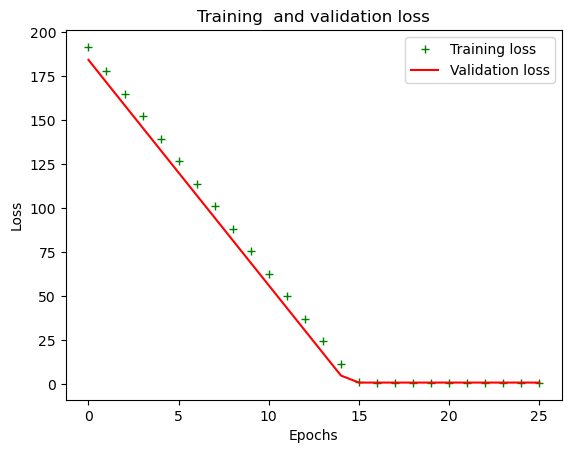

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, 'g+', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training  and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
prediction=model.predict(test_genrator)
prediction.shape

from keras.layers import concatenate
print(test.shape)
test1=test[n_input:,:]
print(test1.shape,type(test1))
print(type(prediction))
prediction1= concatenate((prediction,test1),axis=1)


rescaled_prediction = scaler.inverse_transform(prediction1)
print('rescaled_prediction shape', rescaled_prediction.shape)
#print(rescaled_prediction[-5:,0])
#print(rescaled_prediction[:,0])
rescaled_prediction_pollution=rescaled_prediction[:len(test_genrator),0]
print(rescaled_prediction_pollution.shape)
test_data_actual_scale=scaler.inverse_transform(test)
print('test_data_actual_scale shape', test_data_actual_scale.shape)
test_data_actual_pollution=test_data_actual_scale[22:len(test_genrator)+22,0]
#test_data_actual_pollution=test_data_actual_scale[0:30,0]
print(test_data_actual_pollution.shape)

NameError: name 'test_genrator' is not defined

In [ ]:
plt.figure(figsize=(30,6))  
plt.plot(rescaled_prediction_pollution, color= 'green', label = 'Predicted Pollution level')
plt.plot(test_data_actual_pollution , color = 'red', label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()

In [ ]:
from math import sqrt
rmse = sqrt(mean_squared_error(rescaled_prediction_pollution,test_data_actual_pollution))
print('Test RMSE: %.3f' % rmse)

from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(test_data_actual_pollution,rescaled_prediction_pollution)
print('Test MAE: %.3f' % mae)

from sklearn.metrics import mean_absolute_percentage_error
mape=mean_absolute_percentage_error(test_data_actual_pollution,rescaled_prediction_pollution)
print('Test MAPE: %.3f' % mape)

In [ ]:
v1=v[3]
res=pd.read_csv('../RESULT_Sheet1.csv')
res=res.set_index('DataSets')
res.at[str(v1), 'B-R'] = rmse
res.at[str(v1), 'B-MA'] = mae
res.at[str(v1), 'B-MP'] = mape
res.to_csv('../RESULT_Sheet1.csv')

In [ ]:
df1=pd.read_csv('../Pri_DataSets/'+v[3]+'.csv')
#df1['bilstm_actual'] = pd.DataFrame(test_data_actual_pollution)
df1['BiLSTM'+'_predicted']=pd.DataFrame(rescaled_prediction_pollution)
df1.to_csv('../Pri_DataSets/'+v[3]+'.csv')

# SEQ 2 SEQ